In [1]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import pandas as pd
import numpy as np

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [2]:

# Loading dataset
data = load_diabetes()
X = data.data
y = data.target
feature_names = data.feature_names

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Features:", feature_names)

# Put into a DataFrame for exploration
dfX = pd.DataFrame(X, columns=feature_names)
s_y = pd.Series(y, name="target")

# Basic feature stats
stats = dfX.agg(["mean", "std", "min", "max"]).T
print("\n")
print("Feature summary stats:")
display(stats)

# Target stats
print("\n")
print("Target summary:")
display(s_y.describe())

# Train/test split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n")
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

X shape: (442, 10)
y shape: (442,)
Features: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


Feature summary stats:


,mean,std,min,max
age,-2.511817e-19,0.047619,-0.107226,0.110727
sex,1.230790e-17,0.047619,-0.044642,0.050680
bmi,-2.245564e-16,0.047619,-0.090275,0.170555
bp,-4.797570e-17,0.047619,-0.112399,0.132044
s1,-1.381499e-17,0.047619,-0.126781,0.153914
s2,3.918434e-17,0.047619,-0.115613,0.198788
s3,-5.777179e-18,0.047619,-0.102307,0.181179
s4,-9.042540e-18,0.047619,-0.076395,0.185234
s5,9.293722e-17,0.047619,-0.126097,0.133597
s6,1.130318e-17,0.047619,-0.137767,0.135612




Target summary:


,target
count,442.000000
mean,152.133484
std,77.093005
min,25.000000
25%,87.000000
50%,140.500000
75%,211.500000
max,346.000000




Train shapes: (353, 10) (353,)
Test shapes: (89, 10) (89,)


In [3]:

# Baseline model (all 10 features)
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test  = lr.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test  = r2_score(y_test, y_pred_test)

print(f"Baseline Linear Regression R^2 (train): {r2_train:.4f}")
print(f"Baseline Linear Regression R^2 (test) : {r2_test:.4f}")

# Coefficients table for baseline
baseline_coef = pd.Series(lr.coef_, index=feature_names).sort_values(key=np.abs, ascending=False)
display(baseline_coef.to_frame(name="coef (sorted by |coef|)"))

Baseline Linear Regression R^2 (train): 0.5279
Baseline Linear Regression R^2 (test) : 0.4526


,coef (sorted by |coef|)
s1,-931.488846
s5,736.198859
bmi,542.428759
s2,518.062277
bp,347.703844
s4,275.317902
sex,-241.964362
s3,163.419983
s6,48.670657
age,37.904021


In [4]:

estimator = LinearRegression()

rfe_rows = []          # summary rows: k, r2, selected features
coef_rows = []         # coefficient vectors for each k (length 10)
ranking_rows = []      # rankings for each k

n_features_total = X_train.shape[1]

for k in range(n_features_total, 0, -1):
    rfe = RFE(estimator=estimator, n_features_to_select=k)
    rfe.fit(X_train, y_train)

    # Predict using selected features
    y_pred_test = rfe.predict(X_test)
    r2 = r2_score(y_test, y_pred_test)

    support = rfe.support_
    selected = [name for name, keep in zip(feature_names, support) if keep]

    # rfe.estimator_ is the fitted estimator on the selected features
    coefs_selected = rfe.estimator_.coef_

    # Map coefficients back onto the full 10-feature space
    coefs_full = np.zeros(n_features_total)
    coefs_full[support] = coefs_selected

    rfe_rows.append({
        "k_features": k,
        "r2_test": r2,
        "selected_features": ", ".join(selected)
    })
    coef_rows.append(coefs_full)
    ranking_rows.append(rfe.ranking_)

# Results tables
rfe_results = pd.DataFrame(rfe_rows).sort_values("k_features", ascending=False).reset_index(drop=True)
coef_table = pd.DataFrame(
    coef_rows,
    columns=feature_names
)
coef_table.insert(0, "k_features", list(range(n_features_total, 0, -1)))



In [5]:
print("RFE summary:")
display(rfe_results)



RFE summary:


,k_features,r2_test,selected_features
0,10,0.452603,"age, sex, bmi, bp, s1, s2, s3, s4, s5, s6"
1,9,0.458659,"sex, bmi, bp, s1, s2, s3, s4, s5, s6"
2,8,0.455901,"sex, bmi, bp, s1, s2, s3, s4, s5"
3,7,0.458255,"sex, bmi, bp, s1, s2, s4, s5"
4,6,0.462777,"sex, bmi, bp, s1, s2, s5"
5,5,0.438201,"bmi, bp, s1, s2, s5"
6,4,0.446404,"bmi, s1, s2, s5"
7,3,0.445095,"bmi, s1, s5"
8,2,0.452293,"bmi, s5"
9,1,0.233350,bmi


In [6]:
print("Coefficient table:")
display(coef_table)



Coefficient table:


,k_features,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,10,37.904021,-241.964362,542.428759,347.703844,-931.488846,518.062277,163.419983,275.317902,736.198859,48.670657
1,9,0.000000,-236.649588,542.799508,354.211438,-936.350589,528.796592,167.800414,270.396514,744.447429,53.350483
2,8,0.000000,-233.754686,550.744365,363.791753,-947.823133,541.585796,172.250588,277.741072,761.921177,0.000000
3,7,0.000000,-235.364224,551.866448,362.356114,-660.643160,343.348089,0.000000,185.140764,664.774591,0.000000
4,6,0.000000,-215.267423,557.314167,350.178667,-851.515734,591.093315,0.000000,0.000000,803.121285,0.000000
5,5,0.000000,0.000000,597.892739,306.647913,-655.560612,409.622184,0.000000,0.000000,728.643647,0.000000
6,4,0.000000,0.000000,691.460102,0.000000,-592.977874,362.950323,0.000000,0.000000,783.168538,0.000000
7,3,0.000000,0.000000,737.685594,0.000000,-228.339889,0.000000,0.000000,0.000000,680.224653,0.000000
8,2,0.000000,0.000000,732.109021,0.000000,0.000000,0.000000,0.000000,0.000000,562.226535,0.000000
9,1,0.000000,0.000000,998.577689,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


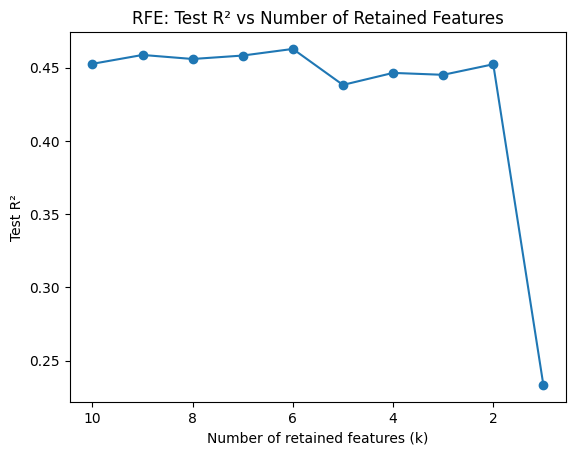

In [7]:
# Plot R^2 vs number of features retained
plt.figure()
plt.plot(rfe_results["k_features"], rfe_results["r2_test"], marker="o")
plt.xlabel("Number of retained features (k)")
plt.ylabel("Test R²")
plt.title("RFE: Test R² vs Number of Retained Features")
plt.gca().invert_xaxis()
plt.show()

In [8]:
# Sort results by k ascending (1 -> 10) for marginal improvement calculation
rfe_sorted = rfe_results.sort_values("k_features").reset_index(drop=True)

# Compute marginal improvement when adding one more feature
rfe_sorted["delta_r2"] = rfe_sorted["r2_test"].diff()

display(rfe_sorted)

threshold = 0.01

# Find smallest k such that adding another feature improves R^2 by < threshold
optimal_k = None

for i in range(1, len(rfe_sorted)):
    if rfe_sorted.loc[i, "delta_r2"] < threshold:
        optimal_k = rfe_sorted.loc[i-1, "k_features"]
        break

# If never drops below threshold, use full model
if optimal_k is None:
    optimal_k = rfe_sorted.iloc[-1]["k_features"]

print(f"Optimal number of features (threshold = {threshold}): {optimal_k}")

,k_features,r2_test,selected_features,delta_r2
0,1,0.233350,bmi,NaN
1,2,0.452293,"bmi, s5",0.218942
2,3,0.445095,"bmi, s1, s5",-0.007198
3,4,0.446404,"bmi, s1, s2, s5",0.001310
4,5,0.438201,"bmi, bp, s1, s2, s5",-0.008203
5,6,0.462777,"sex, bmi, bp, s1, s2, s5",0.024575
6,7,0.458255,"sex, bmi, bp, s1, s2, s4, s5",-0.004521
7,8,0.455901,"sex, bmi, bp, s1, s2, s3, s4, s5",-0.002354
8,9,0.458659,"sex, bmi, bp, s1, s2, s3, s4, s5, s6",0.002758
9,10,0.452603,"age, sex, bmi, bp, s1, s2, s3, s4, s5, s6",-0.006056


Optimal number of features (threshold = 0.01): 2
